# Cleaned Text Length Analysis for Tier Configuration

### Import libraries

In [6]:
import os
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

In [7]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

### Load cleaned data

In [8]:
db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/summarization/data/processed_documents.db"

conn = sqlite3.connect(db_path)

query = """
    SELECT 
        id,
        celex_number,
        total_words,
        summary_word_count,
        compression_ratio
    FROM processed_documents
"""
df = pd.read_sql_query(query, conn)
conn.close()

### Calculate text length metrics

In [9]:
print("Text Length Statistics (words):")
print(f"Mean: {df['total_words'].mean():.2f}")
print(f"Median: {df['total_words'].median():.2f}")
print(f"Std Dev: {df['total_words'].std():.2f}")
print(f"Min: {df['total_words'].min()}")
print(f"Max: {df['total_words'].max()}")

# Calculate percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    print(f"{p}th percentile: {df['total_words'].quantile(p/100):.2f}")

Text Length Statistics (words):
Mean: 5678.37
Median: 747.00
Std Dev: 21699.47
Min: 14
Max: 660038

Percentiles:
25th percentile: 387.00
50th percentile: 747.00
75th percentile: 2465.00
90th percentile: 11349.20
95th percentile: 27177.80
99th percentile: 77485.36


### Visualize distribution

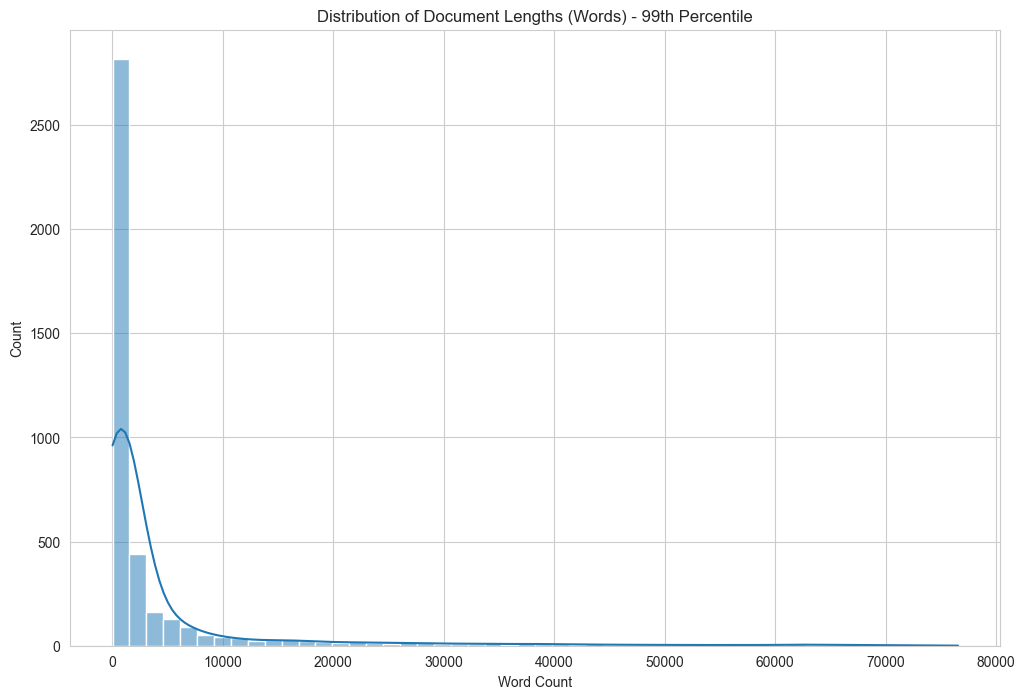

In [10]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df[df['total_words'] <= df['total_words'].quantile(0.99)], 
            x='total_words', bins=50, kde=True)
plt.title("Distribution of Document Lengths (Words) - 99th Percentile")
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.show()

### Analyze documents by tier

Documents per tier:
Tier 1 (0-600): 1751 documents (42.04%)
Tier 2 (601-2500): 1380 documents (33.13%)
Tier 3 (2501-20000): 758 documents (18.20%)
Tier 4 (>20000): 276 documents (6.63%)


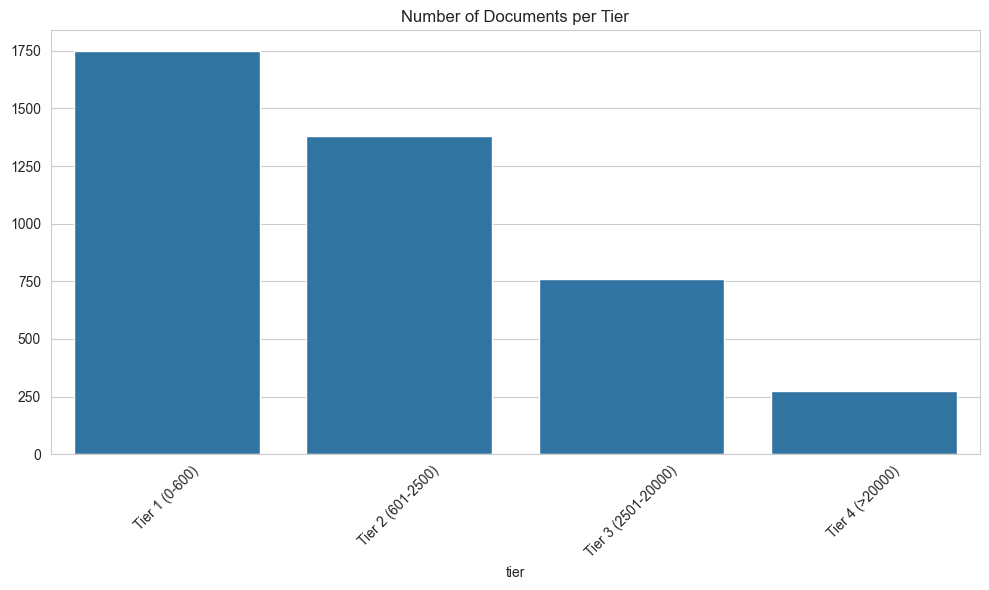

In [11]:
# Define tier thresholds
def get_tier(total_words):
    if total_words <= 600:
        return 'Tier 1 (0-600)'
    elif total_words <= 2500:
        return 'Tier 2 (601-2500)'
    elif total_words <= 20000:
        return 'Tier 3 (2501-20000)'
    else:
        return 'Tier 4 (>20000)'

df['tier'] = df['total_words'].apply(get_tier)

# Count documents per tier
tier_counts = df['tier'].value_counts().sort_index()
print("Documents per tier:")
for tier, count in tier_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{tier}: {count} documents ({percentage:.2f}%)")

# Visualize tier distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=tier_counts.index, y=tier_counts.values)
plt.title("Number of Documents per Tier")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Outlier Analysis Results:

IQR Method:
Q1: 387.00 words
Q3: 2465.00 words
IQR: 2078.00 words
Lower bound: -2730.00 words
Upper bound: 5582.00 words
Number of outliers: 653
Percentage of outliers: 15.68%

Z-score Method (|z| > 3):
Mean: 5678.37 words
Standard deviation: 21699.47 words
Number of outliers: 45
Percentage of outliers: 1.08%


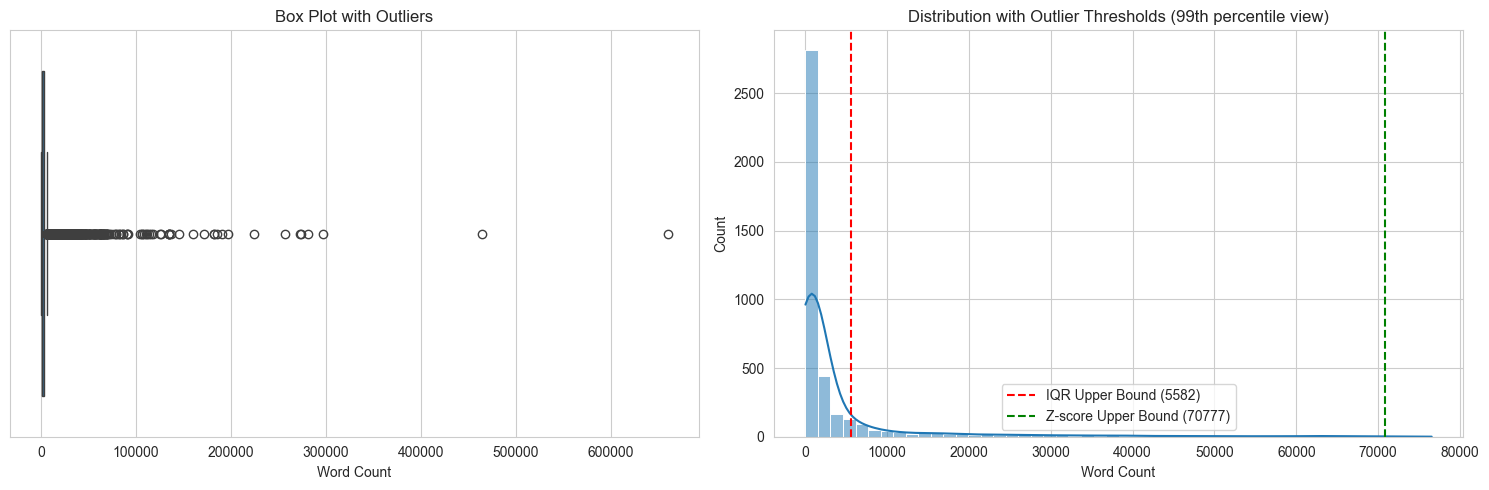

In [13]:
# Calculate outliers using IQR method and z-score method
def analyze_outliers(data, column='total_words', z_threshold=3):
    # IQR Method
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Z-score Method
    mean = data[column].mean()
    std = data[column].std()
    z_scores = (data[column] - mean) / std
    z_score_outliers = data[abs(z_scores) > z_threshold]
    
    print("Outlier Analysis Results:")
    print("\nIQR Method:")
    print(f"Q1: {Q1:.2f} words")
    print(f"Q3: {Q3:.2f} words")
    print(f"IQR: {IQR:.2f} words")
    print(f"Lower bound: {lower_bound:.2f} words")
    print(f"Upper bound: {upper_bound:.2f} words")
    print(f"Number of outliers: {len(data[(data[column] < lower_bound) | (data[column] > upper_bound)])}")
    print(f"Percentage of outliers: {(len(data[(data[column] < lower_bound) | (data[column] > upper_bound)]) / len(data) * 100):.2f}%")
    
    print("\nZ-score Method (|z| > 3):")
    print(f"Mean: {mean:.2f} words")
    print(f"Standard deviation: {std:.2f} words")
    print(f"Number of outliers: {len(z_score_outliers)}")
    print(f"Percentage of outliers: {(len(z_score_outliers) / len(data) * 100):.2f}%")
    
    # Visualize outliers
    plt.figure(figsize=(15, 5))
    
    # Box plot
    plt.subplot(121)
    sns.boxplot(x=data[column])
    plt.title("Box Plot with Outliers")
    plt.xlabel("Word Count")
    
    # Distribution with outlier thresholds
    plt.subplot(122)
    sns.histplot(data=data[data[column] <= data[column].quantile(0.99)], 
                x=column, bins=50, kde=True)
    plt.axvline(x=upper_bound, color='r', linestyle='--', label=f'IQR Upper Bound ({upper_bound:.0f})')
    plt.axvline(x=mean + z_threshold*std, color='g', linestyle='--', 
                label=f'Z-score Upper Bound ({mean + z_threshold*std:.0f})')
    plt.title("Distribution with Outlier Thresholds (99th percentile view)")
    plt.xlabel("Word Count")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'iqr_upper_bound': upper_bound,
        'zscore_upper_bound': mean + z_threshold*std,
        'percentiles': {p: data[column].quantile(p/100) for p in percentiles}
    }

# Run the analysis
outlier_analysis = analyze_outliers(df)

Analysis for All Documents:
Z-score Threshold Analysis:

Threshold Statistics:
 z_threshold  word_threshold  n_outliers  n_retained  pct_retained  max_retained_words  min_retained_words
        1.00        27377.84         206        3959         95.05               27374                  14
        1.50        38227.57         137        4028         96.71               38227                  14
        2.00        49077.30          99        4066         97.62               49051                  14
        2.50        59927.04          73        4092         98.25               59883                  14
        3.00        70776.77          45        4120         98.92               70046                  14
        3.50        81626.50          39        4126         99.06               81382                  14


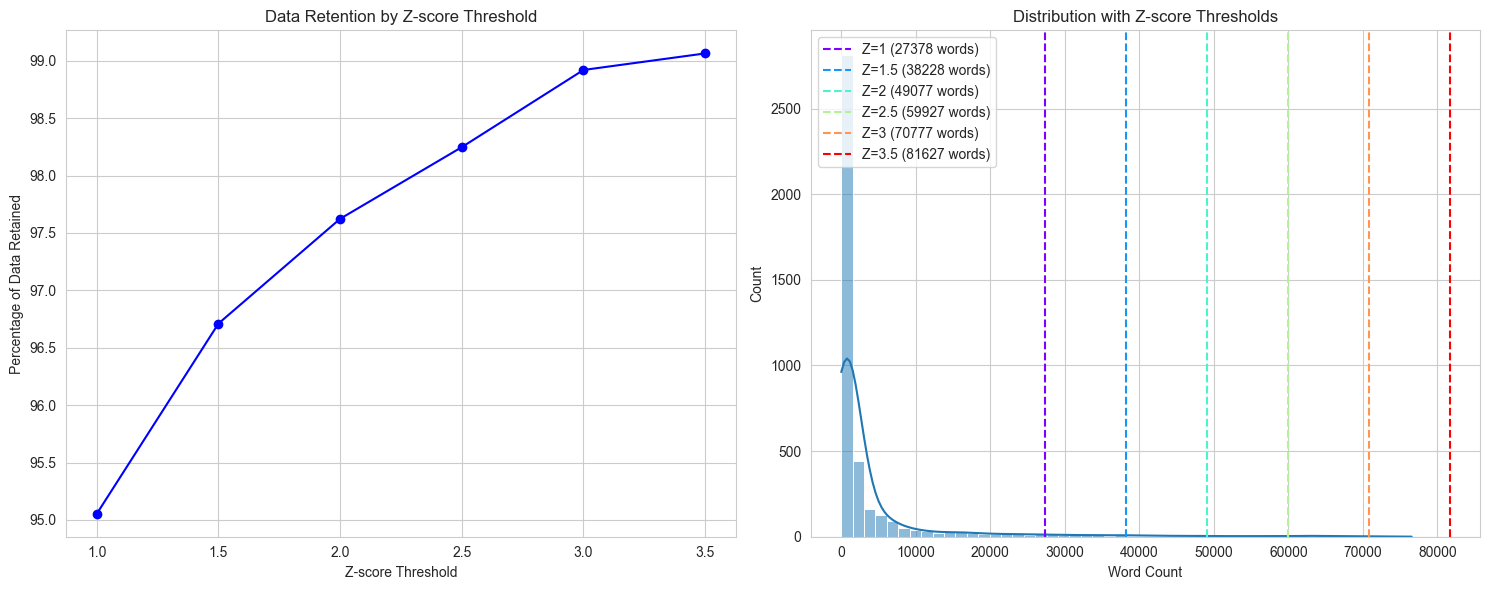


Optimal Z-score Threshold (targeting 95.0% retention):
Z-score threshold: 5.00
Word count threshold: 114176
Actual retention: 99.40%

Optimal Z-score Threshold (targeting 97.5% retention):
Z-score threshold: 5.00
Word count threshold: 114176
Actual retention: 99.40%

Optimal Z-score Threshold (targeting 99.0% retention):
Z-score threshold: 5.00
Word count threshold: 114176
Actual retention: 99.40%


In [15]:
def analyze_zscore_thresholds(data, column='total_words', thresholds=[1, 1.5, 2, 2.5, 3, 3.5]):
    """
    Analyze different z-score thresholds and their impact on data retention
    """
    mean = data[column].mean()
    std = data[column].std()
    z_scores = (data[column] - mean) / std
    
    results = []
    for z in thresholds:
        outliers = data[abs(z_scores) > z]
        retained = data[abs(z_scores) <= z]
        
        results.append({
            'z_threshold': z,
            'word_threshold': mean + z*std,
            'n_outliers': len(outliers),
            'n_retained': len(retained),
            'pct_retained': (len(retained) / len(data)) * 100,
            'max_retained_words': retained[column].max(),
            'min_retained_words': retained[column].min()
        })
    
    # Convert to DataFrame for nice display
    results_df = pd.DataFrame(results)
    
    print("Z-score Threshold Analysis:")
    print("\nThreshold Statistics:")
    print(results_df.to_string(index=False, float_format=lambda x: '{:.2f}'.format(x)))
    
    # Visualize the impact of different thresholds
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Retention percentage
    plt.subplot(121)
    plt.plot(results_df['z_threshold'], results_df['pct_retained'], 'bo-')
    plt.title('Data Retention by Z-score Threshold')
    plt.xlabel('Z-score Threshold')
    plt.ylabel('Percentage of Data Retained')
    plt.grid(True)
    
    # Plot 2: Word count thresholds
    plt.subplot(122)
    sns.histplot(data=data[data[column] <= data[column].quantile(0.99)], 
                x=column, bins=50, kde=True)
    
    # Add vertical lines for different z-score thresholds
    colors = plt.cm.rainbow(np.linspace(0, 1, len(thresholds)))
    for z, color in zip(thresholds, colors):
        threshold = mean + z*std
        plt.axvline(x=threshold, color=color, linestyle='--', 
                   label=f'Z={z} ({threshold:.0f} words)')
    
    plt.title('Distribution with Z-score Thresholds')
    plt.xlabel('Word Count')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df

# Calculate optimal threshold based on retention target
def find_optimal_zscore(data, target_retention=0.95, column='total_words'):
    """
    Find the optimal z-score threshold that retains approximately target_retention of the data
    """
    mean = data[column].mean()
    std = data[column].std()
    z_scores = (data[column] - mean) / std
    
    # Binary search for optimal threshold
    left, right = 0, 10
    best_z = None
    best_retention = None
    
    while left <= right:
        mid = (left + right) / 2
        retention = (abs(z_scores) <= mid).mean()
        
        if best_z is None or abs(retention - target_retention) < abs(best_retention - target_retention):
            best_z = mid
            best_retention = retention
        
        if retention > target_retention:
            left = mid + 0.1
        else:
            right = mid - 0.1
            
    word_threshold = mean + best_z*std
    
    print(f"\nOptimal Z-score Threshold (targeting {target_retention*100}% retention):")
    print(f"Z-score threshold: {best_z:.2f}")
    print(f"Word count threshold: {word_threshold:.0f}")
    print(f"Actual retention: {best_retention*100:.2f}%")
    
    return best_z, word_threshold, best_retention

# Run the analysis for all documents
print("Analysis for All Documents:")
threshold_analysis = analyze_zscore_thresholds(df)

# Find optimal thresholds for different retention targets
for retention in [0.95, 0.975, 0.99]:
    find_optimal_zscore(df, retention)

In [16]:
# Analyze documents above the threshold
threshold = 114176
docs_above = df[df['total_words'] > threshold]
docs_below = df[df['total_words'] <= threshold]

print(f"Analysis for threshold of {threshold:,} words:")
print(f"\nDocuments above threshold: {len(docs_above):,}")
print(f"Documents below threshold: {len(docs_below):,}")
print(f"Total documents: {len(df):,}")
print(f"\nPercentage excluded: {(len(docs_above) / len(df) * 100):.2f}%")
print(f"Percentage retained: {(len(docs_below) / len(df) * 100):.2f}%")

Analysis for threshold of 114,176 words:

Documents above threshold: 25
Documents below threshold: 4,140
Total documents: 4,165

Percentage excluded: 0.60%
Percentage retained: 99.40%


In [17]:
# Get the celex numbers for documents above threshold
outlier_docs = docs_above[['celex_number', 'total_words']].sort_values('total_words', ascending=False)
print(f"Documents above {threshold:,} words ({len(outlier_docs)} documents):")
print(outlier_docs.to_string(index=False))

# Save celex numbers to a list
celex_numbers = outlier_docs['celex_number'].tolist()

Documents above 114,176 words (25 documents):
celex_number  total_words
  32024R1623       660038
  32024R2547       464339
  32024R2754       297415
  32024R1866       281006
 22024A01759       273976
  32023R2616       272489
  32025L0002       256905
 22024A02953       224060
  32024L1619       196638
  32023R2842       190175
  32024R2493       185246
  32023R2772       181918
  32024R2987       181723
  32023L2413       171688
  32024R1745       159657
  22024D0390       145124
  32024R2509       136414
  32023R2485       134655
  32024R1865       134518
  32024L0927       134191
  32024R2809       134098
  32024R0791       126057
  32023R2878       125369
  32023R2122       117462
  32023R2486       116133


In [22]:
# Connect to eurlex database to get more information
eurlex_db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/scraper/data/eurlex.db"
conn = sqlite3.connect(eurlex_db_path)

# Query to get detailed information about these documents
query = """
    SELECT 
        d.document_id,
        d.celex_number,
        d.title,
        d.identifier,
        d.eli_uri,
        d.responsible_body_id,
        f.form_name
    FROM documents d
    LEFT JOIN forms f ON d.form_id = f.form_id
    WHERE d.celex_number IN ({})
""".format(','.join('?' * len(celex_numbers)))

df_details = pd.read_sql_query(query, conn, params=celex_numbers)
conn.close()


Document types distribution:
form_name
Regulation                                                        9
Delegated regulation                                              5
Directive                                                         4
Implementing regulation                                           4
International agreement                                           2
Decision adopted by bodies created by international agreements    1
Name: count, dtype: int64

Responsible bodies distribution:
responsible_body_id
1.0     4
11.0    2
41.0    1
31.0    1
19.0    1
65.0    1
29.0    1
10.0    1
Name: count, dtype: int64

Detailed document information:

Document ID: 1873
CELEX: 22024A01759
Type: International agreement
Responsible Body ID: nan
Identifier: 
Title: Advanced Framework Agreement between the European Union and its Member States, of the one part, and the Republic of Chile, of the other part
ELI URI: http://data.europa.eu/eli/agree_internation/2024/1759

Document ID: 305

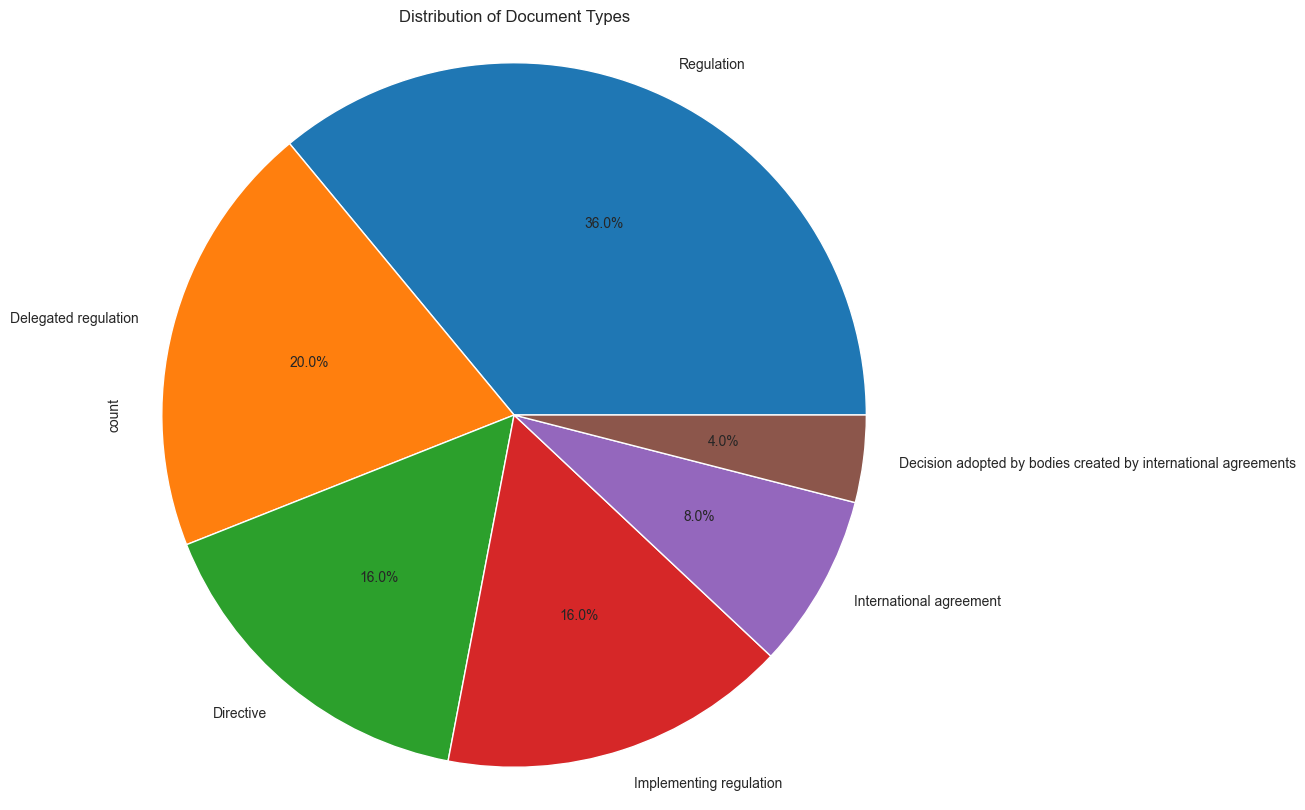

In [24]:
# Display document types distribution
print("\nDocument types distribution:")
print(df_details['form_name'].value_counts())

# Display responsible bodies distribution
print("\nResponsible bodies distribution:")
print(df_details['responsible_body_id'].value_counts())

# Display full details for each document
print("\nDetailed document information:")
for _, row in df_details.iterrows():
    print("\n" + "="*80)
    print(f"Document ID: {row['document_id']}")
    print(f"CELEX: {row['celex_number']}")
    print(f"Type: {row['form_name']}")
    print(f"Responsible Body ID: {row['responsible_body_id']}")
    print(f"Identifier: {row['identifier']}")
    print(f"Title: {row['title']}")
    print(f"ELI URI: {row['eli_uri']}")

# Create pie chart of document types
plt.figure(figsize=(10, 10))
df_details['form_name'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Document Types')
plt.axis('equal')
plt.show()

In [26]:
# Get document IDs that are below the threshold
docs_below_threshold = df[df['total_words'] <= threshold]['id'].tolist()

# Connect to the database
db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/summarization/data/processed_documents.db"
conn = sqlite3.connect(db_path)

# Query to get section information for documents below threshold
query = """
    SELECT 
        s.id,
        s.document_id,
        s.title,
        s.section_type,
        s.section_order,
        s.word_count,
        s.summary_word_count,
        s.compression_ratio,
        s.tier
    FROM document_sections s
    WHERE s.document_id IN ({})
""".format(','.join('?' * len(docs_below_threshold)))

df_sections = pd.read_sql_query(query, conn, params=docs_below_threshold)
conn.close()

In [27]:
print("Section Word Count Analysis:")
print("\nOverall Statistics:")
print(f"Total number of sections: {len(df_sections):,}")
print(f"Mean word count: {df_sections['word_count'].mean():.2f}")
print(f"Median word count: {df_sections['word_count'].median():.2f}")
print(f"Std dev: {df_sections['word_count'].std():.2f}")
print(f"Min word count: {df_sections['word_count'].min()}")
print(f"Max word count: {df_sections['word_count'].max()}")

# Calculate percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    print(f"{p}th percentile: {df_sections['word_count'].quantile(p/100):.2f}")

# Distribution by section type
print("\nWord count statistics by section type:")
section_stats = df_sections.groupby('section_type').agg({
    'word_count': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)
print(section_stats)

# Visualizations
plt.figure(figsize=(15, 10))

Section Word Count Analysis:

Overall Statistics:
Total number of sections: 48,145
Mean word count: 381.12
Median word count: 81.00
Std dev: 1740.71
Min word count: 1
Max word count: 75587

Percentiles:
25th percentile: 28.00
50th percentile: 81.00
75th percentile: 259.00
90th percentile: 630.00
95th percentile: 1096.00
99th percentile: 5468.36

Word count statistics by section type:
              word_count                                    
                   count     mean median      std min    max
section_type                                                
header              4140    31.92   28.0    15.40   4    191
main                4140  1645.31  464.0  4513.82   7  56508
oj-ti-art          20755   217.65   57.0  1049.45   2  41485
oj-ti-grseq-1      19110   360.45  109.0  1273.82   1  75587


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [ ]:
# Connect to eurlex database to get more information
eurlex_db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/scraper/data/eurlex.db"
conn = sqlite3.connect(eurlex_db_path)

# Query to get detailed information about these documents
query = """
    SELECT 
        d.document_id,
        d.celex_number,
        f.form_name,
        d.title,
        d.date_of_document,
        d.date_of_effect,
        d.date_of_end_validity,
        d.content
    FROM documents d
    LEFT JOIN forms f ON d.form_id = f.form_id
    WHERE d.celex_number IN ({})
""".format(','.join('?' * len(celex_numbers)))

df_details = pd.read_sql_query(query, conn, params=celex_numbers)
conn.close()

In [ ]:
# Connect to eurlex database to get more information
eurlex_db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/scraper/data/eurlex.db"
conn = sqlite3.connect(eurlex_db_path)

# Query to get detailed information about these documents
query = """
    SELECT 
        d.document_id,
        d.celex_number,
        f.form_name,
        d.title,
        d.date_of_document,
        d.date_of_effect,
        d.date_of_end_validity,
        d.content
    FROM documents d
    LEFT JOIN forms f ON d.form_id = f.form_id
    WHERE d.celex_number IN ({})
""".format(','.join('?' * len(celex_numbers)))

df_details = pd.read_sql_query(query, conn, params=celex_numbers)
conn.close()

In [28]:
# Connect to eurlex database to get more information
eurlex_db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/scraper/data/eurlex.db"
conn = sqlite3.connect(eurlex_db_path)

# Query to get detailed information about these documents
query = """
    SELECT 
        d.document_id,
        d.celex_number,
        f.form_name,
        d.title,
        d.date_of_document,
        d.date_of_effect,
        d.date_of_end_validity,
        d.content
    FROM documents d
    LEFT JOIN forms f ON d.form_id = f.form_id
    WHERE d.celex_number IN ({})
""".format(','.join('?' * len(celex_numbers)))

df_details = pd.read_sql_query(query, conn, params=celex_numbers)
conn.close()

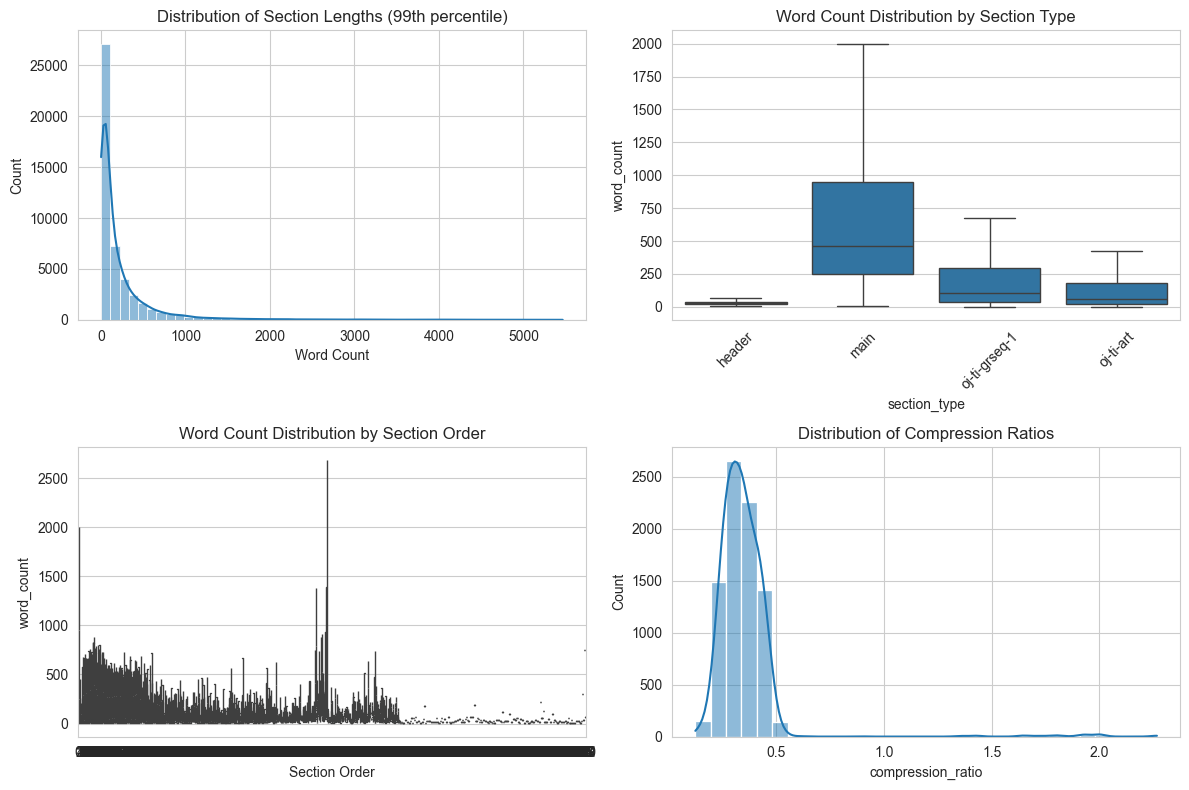


Tier distribution:
tier
1.0    8203
Name: count, dtype: int64

Correlation between section order and word count: -0.052

Top 10 longest sections:
       document_id   section_type  section_order  word_count                             title
28564         2419  oj-ti-grseq-1              2       75587  LIST OF DEFENCE-RELATED PRODUCTS
30813         2653  oj-ti-grseq-1              2       65524                 EXPLANATORY NOTES
15497         1285           main              1       56508                      Main Content
24127         2119           main              1       55532                      Main Content
17693         1511           main              1       54991                      Main Content
25986         2225           main              1       52819                      Main Content
6328           522           main              1       51246                      Main Content
45475         3964           main              1       45468                      Main Conten

In [29]:

# Plot 1: Overall distribution
plt.subplot(221)
sns.histplot(data=df_sections[df_sections['word_count'] <= df_sections['word_count'].quantile(0.99)], 
            x='word_count', bins=50, kde=True)
plt.title('Distribution of Section Lengths (99th percentile)')
plt.xlabel('Word Count')

# Plot 2: Box plot by section type
plt.subplot(222)
sns.boxplot(data=df_sections, x='section_type', y='word_count', 
            showfliers=False)  # Exclude outliers for better visualization
plt.xticks(rotation=45)
plt.title('Word Count Distribution by Section Type')

# Plot 3: Section order vs word count
plt.subplot(223)
sns.boxplot(data=df_sections, x='section_order', y='word_count',
            showfliers=False)
plt.title('Word Count Distribution by Section Order')
plt.xlabel('Section Order')

# Plot 4: Distribution of compression ratios (for sections with summaries)
plt.subplot(224)
sections_with_summaries = df_sections[df_sections['compression_ratio'].notna()]
sns.histplot(data=sections_with_summaries, x='compression_ratio', bins=30, kde=True)
plt.title('Distribution of Compression Ratios')

plt.tight_layout()
plt.show()

# Analyze tier distribution
print("\nTier distribution:")
print(df_sections['tier'].value_counts().sort_index())

# Find the longest sections
print("\nTop 10 longest sections:")
longest_sections = df_sections.nlargest(10, 'word_count')[
    ['document_id', 'section_type', 'section_order', 'word_count', 'title']
]
print(longest_sections.to_string())

Tier 3 Section Analysis:

Number of Tier 3 documents: 758
Total number of sections: 15,155

Word Count Statistics:
Mean word count: 360.74
Median word count: 96.00
Std dev: 963.59
Min word count: 1
Max word count: 17065

Percentiles:
25th percentile: 36.00
50th percentile: 96.00
75th percentile: 262.00
90th percentile: 701.60
95th percentile: 1518.30
99th percentile: 5121.84

Average sections per document: 19.99
Median sections per document: 12.00

Long sections analysis (above 95th percentile - 1518 words):
Number of long sections: 758

Distribution of long sections by type:
section_type
main             390
oj-ti-grseq-1    234
oj-ti-art        134
Name: count, dtype: int64

Top 10 longest sections in Tier 3 documents:
       document_id   section_type  section_order  word_count                                                                                                                                                   title
4808          1503      oj-ti-art             12       1

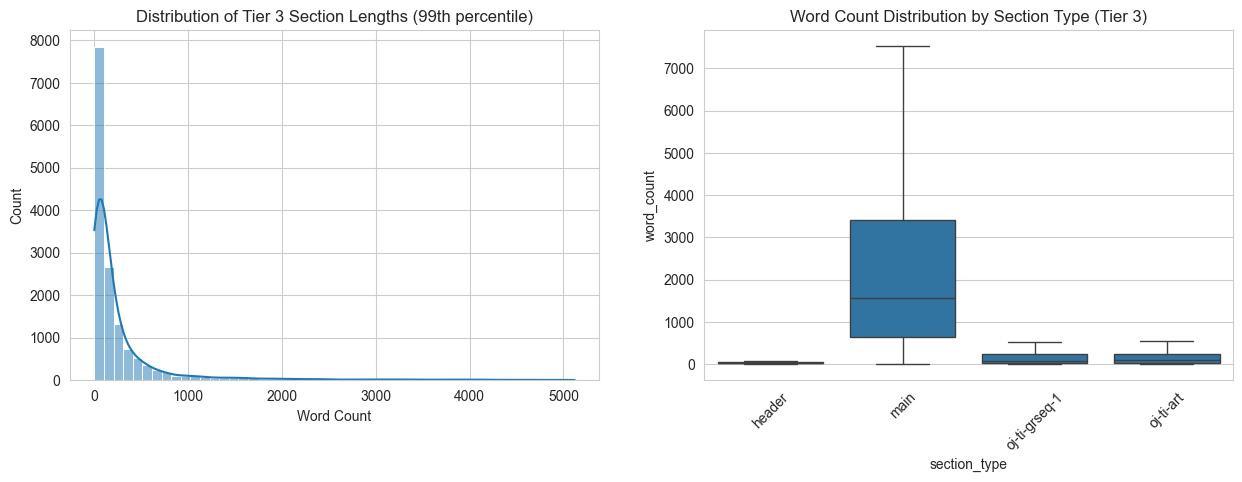

In [30]:
# Get document IDs for Tier 3 documents (2,500 to 20,000 words)
tier3_doc_ids = df[(df['total_words'] > 2500) & (df['total_words'] <= 20000)]['id'].tolist()

# Connect to the database
db_path = "/Users/alexanderbenady/DataThesis/eu-legal-recommender/summarization/data/processed_documents.db"
conn = sqlite3.connect(db_path)

# Query to get section information for Tier 3 documents
query = """
    SELECT 
        s.id,
        s.document_id,
        s.title,
        s.section_type,
        s.section_order,
        s.word_count,
        s.summary_word_count,
        s.compression_ratio,
        s.tier
    FROM document_sections s
    WHERE s.document_id IN ({})
""".format(','.join('?' * len(tier3_doc_ids)))

df_tier3_sections = pd.read_sql_query(query, conn, params=tier3_doc_ids)
conn.close()

print("Tier 3 Section Analysis:")
print(f"\nNumber of Tier 3 documents: {len(tier3_doc_ids):,}")
print(f"Total number of sections: {len(df_tier3_sections):,}")

print("\nWord Count Statistics:")
print(f"Mean word count: {df_tier3_sections['word_count'].mean():.2f}")
print(f"Median word count: {df_tier3_sections['word_count'].median():.2f}")
print(f"Std dev: {df_tier3_sections['word_count'].std():.2f}")
print(f"Min word count: {df_tier3_sections['word_count'].min()}")
print(f"Max word count: {df_tier3_sections['word_count'].max()}")

# Calculate percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    print(f"{p}th percentile: {df_tier3_sections['word_count'].quantile(p/100):.2f}")

# Average sections per document
sections_per_doc = df_tier3_sections.groupby('document_id').size()
print(f"\nAverage sections per document: {sections_per_doc.mean():.2f}")
print(f"Median sections per document: {sections_per_doc.median():.2f}")

# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Overall distribution
plt.subplot(221)
sns.histplot(data=df_tier3_sections[df_tier3_sections['word_count'] <= df_tier3_sections['word_count'].quantile(0.99)], 
            x='word_count', bins=50, kde=True)
plt.title('Distribution of Tier 3 Section Lengths (99th percentile)')
plt.xlabel('Word Count')

# Plot 2: Box plot by section type
plt.subplot(222)
sns.boxplot(data=df_tier3_sections, x='section_type', y='word_count', 
            showfliers=False)  # Exclude outliers for better visualization
plt.xticks(rotation=45)
plt.title('Word Count Distribution by Section Type (Tier 3)')

# Find sections that might be too long for direct summarization
long_section_threshold = df_tier3_sections['word_count'].quantile(0.95)  # 95th percentile
long_sections = df_tier3_sections[df_tier3_sections['word_count'] > long_section_threshold]

print(f"\nLong sections analysis (above 95th percentile - {long_section_threshold:.0f} words):")
print(f"Number of long sections: {len(long_sections)}")
print("\nDistribution of long sections by type:")
print(long_sections['section_type'].value_counts())

# Show the top 10 longest sections
print("\nTop 10 longest sections in Tier 3 documents:")
longest_sections = df_tier3_sections.nlargest(10, 'word_count')[
    ['document_id', 'section_type', 'section_order', 'word_count', 'title']
]
print(longest_sections.to_string())